# Processing the IR dataset

In [1]:
from spectrochempy.api import *
options.log_level=ERROR

SpectroChemPy's API - v.0.1a5.dev
© Copyright 2014-2017 - A.Travert and C.Fernandez @ LCS


## Loading a project

We read the 'HIZECOKE' project saved previously

In [2]:
proj = Project.load('HIZECOKE')
proj

## Preprocessing the IR spectra

Let's replot the data. For this we need to do again the previous pre-processing first.

In addition, we will slice the data in order to keep only the region of interest, between 3990 and 1300 cm$^{-1}$.



### Some notes about slicing

Slicing can be done by index, coordinates or labels (when they are present).

* `proj.P350.IR[:, 10]` for column slicing (here we get the 10th column (with index starting at 0!))
* or `proj.P350.IR[10]` for row slicing

As said above, we can also slice using the real coordinates. For example,

* `proj.P350.IR[:, 3000.0:3100.0]` will select all columns from wavenumbers 3000 to 3100. 

**IMPORTANT** : 

* When doing such slicing, the wavenumbers must be expressed as floating numbers (with the decimal separator present) or it will fail!.

* Note that when using a range of coordinates, both limits needs to be set as SpectroChemPy cannot infer which direction to take (and so results may be impredictable):  
This is ok: `proj.P350.IR[:, 3000.0:3100.0]`, but not this: `proj.P350.IR[:, 3000.0:]`

In [3]:
for p in proj.projects:   
    p.IR[:, 3990.:1300., INPLACE]   # we slice the data inplace 
    p.IR = p.IR - p.IR[:,3990.]     # we remove some offset 

<IPython.core.display.Javascript object>


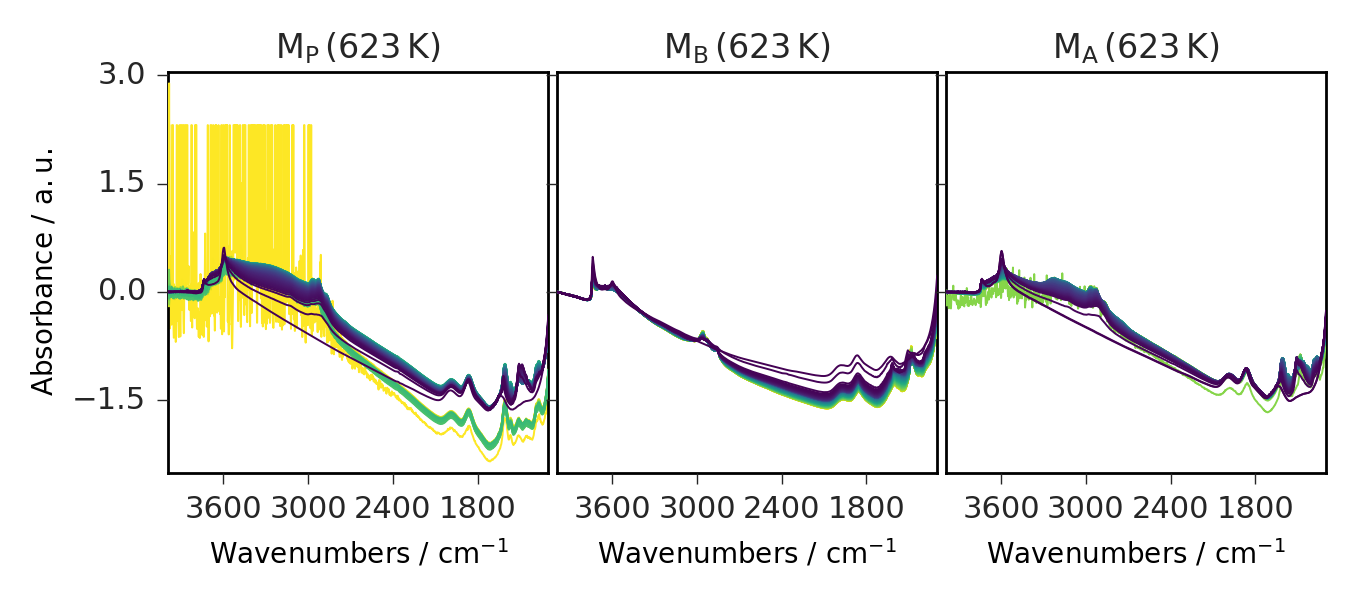

In [4]:
datasets =[]
labels = []

for p in reversed(proj.projects):   # we put the parent first this way
    datasets.append(p.IR)
    labels.append(p.label) 
    
_ = multiplot_stack(sources=datasets, labels=labels, 
                nrow=1, ncol=3, sharex=True, sharez=True, 
                figsize=(6.8,3), dpi=100, style='sans')

## Creating and using project's scripts

In order to avoid having to write this basic pre-processing and plotting function each time we read the initial project, there is two ways:

1. We can save the mofified data and reopen the project with the modified files next time we need them. However, the processing that was applied cannot be modified.
2. The second possibility is to save the processing scripts along with the project, and reapply them next time we will open this project. If a modification is required, any of the scripts can be modified before being applied.

it would be useful to keep the script used here along with the project.

To do so, we will store them in the project, using the `%addscript` magic function.

The syntax is simple!

There are two possibilities: 

1. `%addscript -p <project_name> -o <scriptname> <cell_reference, file or objects>`
1. `%%addscript -p <project_name> -o <scriptname>` 
    
        ...code lines...

where

* `-p <project_name>` to say in wich project we want to strore our script
* `-o <script_name>` to say which name will be used for that script. It must be unique in a project, or confusion may rapidly arise.

That's almost all:
* The script can come from the current cell (in this case modify the command like this: `%%addscript -p <project_name> -o <script_name>` (yes with two `%`). This should be the first line of the cell to use as a script. 
* it can also come from another already executed cell: inthis case with give the `id` (*e.g.,* `3`) of the cell to use or a range of cells to use (*e.g.,* `3-10`)


In [5]:
%addscript -p proj -o plotIR 4

'Script plotIR created.'

In [6]:
%addscript -p proj -o preprocess 3

'Script preprocess created.'

In [7]:
%%addscript -p proj -o print_info
print("samples contained in the project are: %s"%proj.projects_names)

'Script print_info created.'

Let's check that the scripts are stored in the project:

In [8]:
proj

and that a script can be executed!

In [9]:
proj.print_info()

samples contained in the project are: ['A350', 'B350', 'P350']


Now, we save the project... but as we want to keep the original data intacts, we will save only the scripts and keep all data unchanged.

In [10]:
proj.save(overwrite_data=False)

Let's now reload the project in a new object, and check that this is the original data for the dataset

<IPython.core.display.Javascript object>


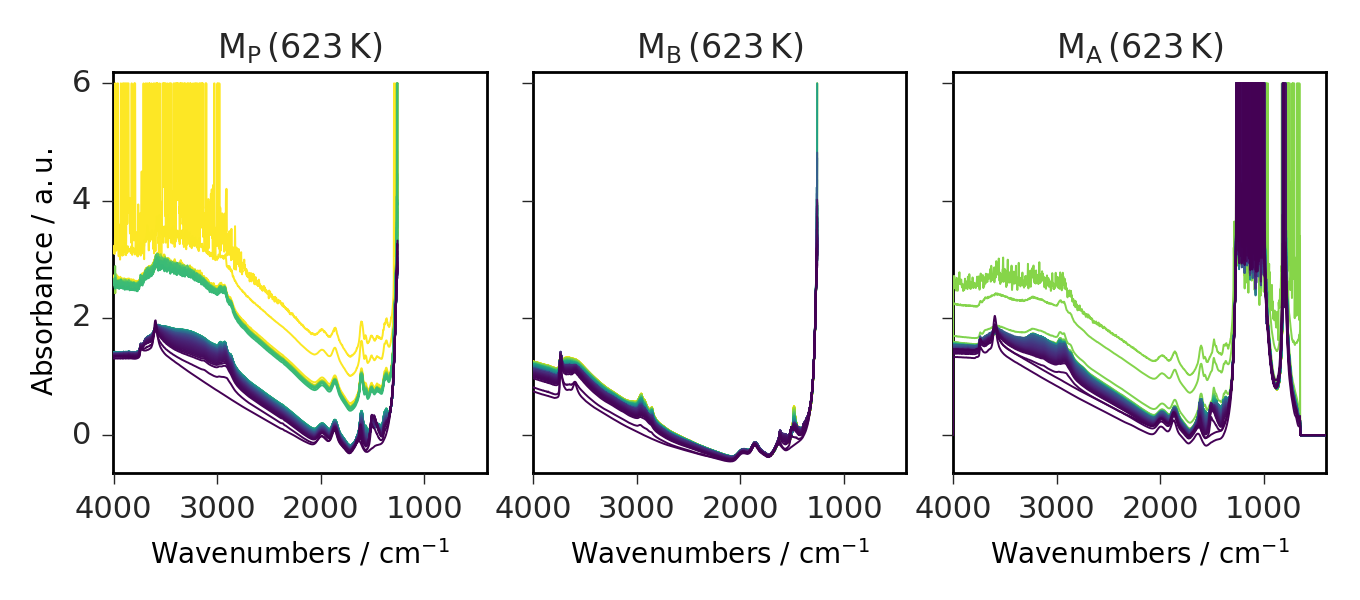

In [11]:
proj = Project.load('HIZECOKE')
proj.plotIR()

We get the original spectra as expected. 

But now we can use the `preprocess` script which is stored in the project, to apply all change that were recorded.

<IPython.core.display.Javascript object>


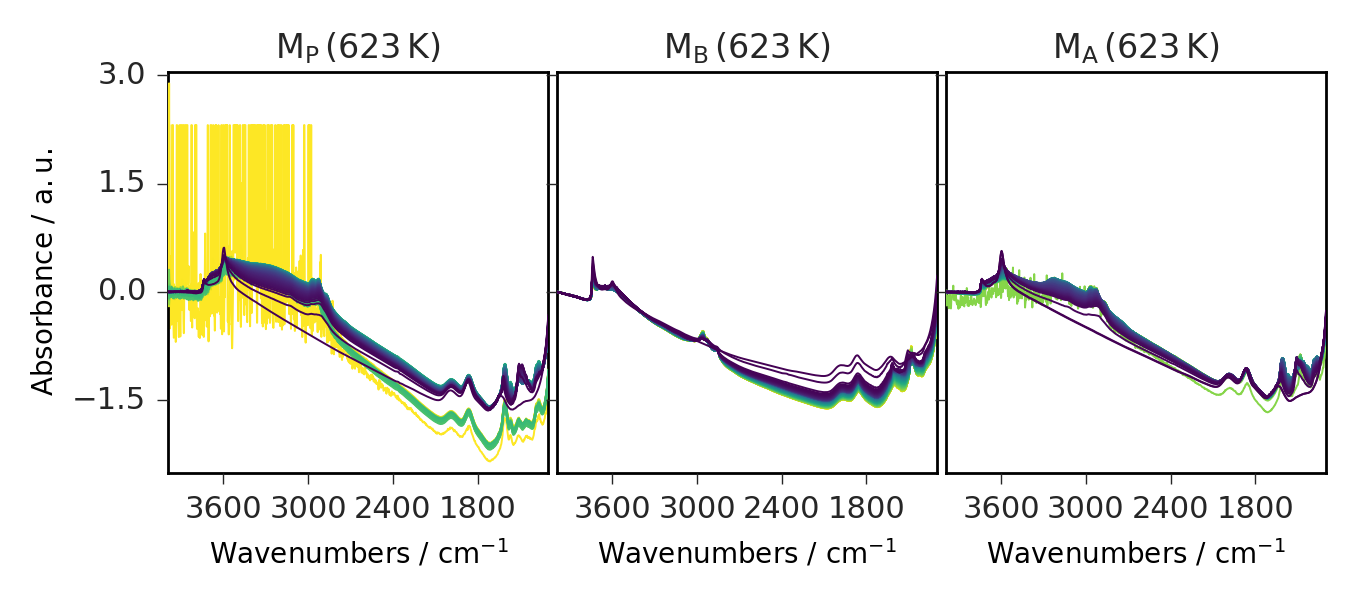

In [12]:
proj.preprocess()
proj.plotIR()

## Masking bad data

### Set a mask on a range of columns
Clearly some of the spectra above displayed have problem with noise, or some experiment artifacts. 
Although we could be tempted to simply remove the data, another way, it to mask these bad data. 

For instance, we may want to mask all data ranging between 2300 and 2700. Let's do that:

<IPython.core.display.Javascript object>


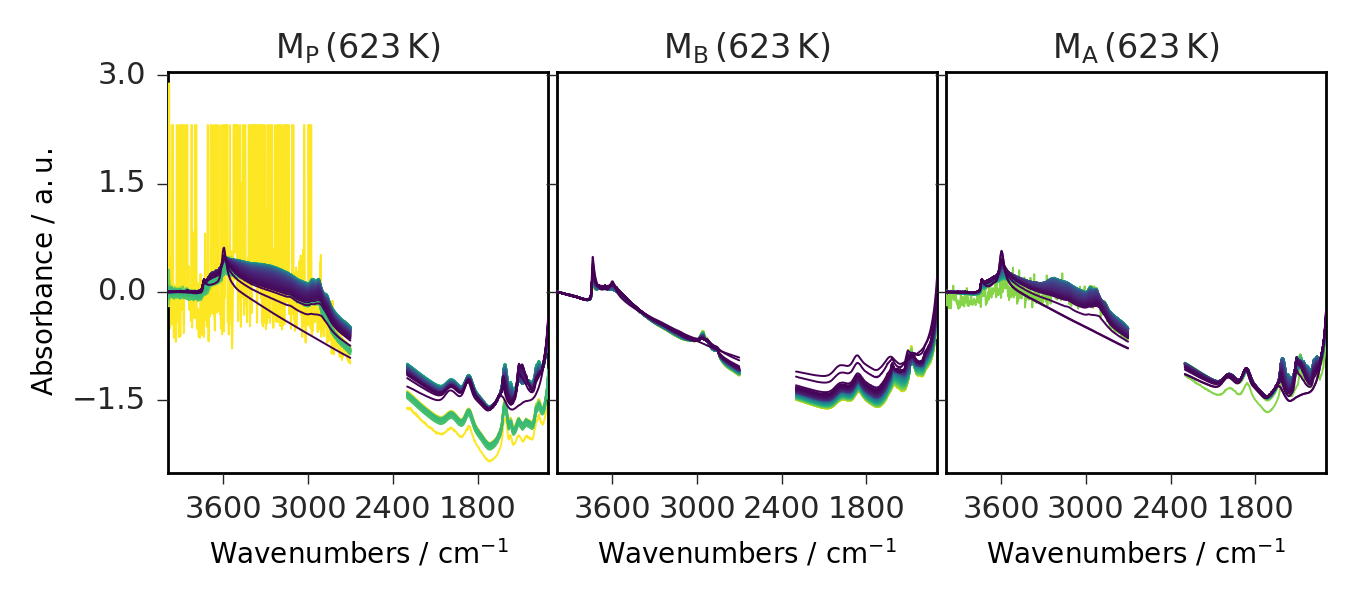

In [13]:
for p in proj.projects:   
    p.IR[:, 2300.:2700.]=masked

proj.plotIR()

### Remove a mask

To remove the mask, we cannot make it selectively. All mask must be removed at the same time:

<IPython.core.display.Javascript object>


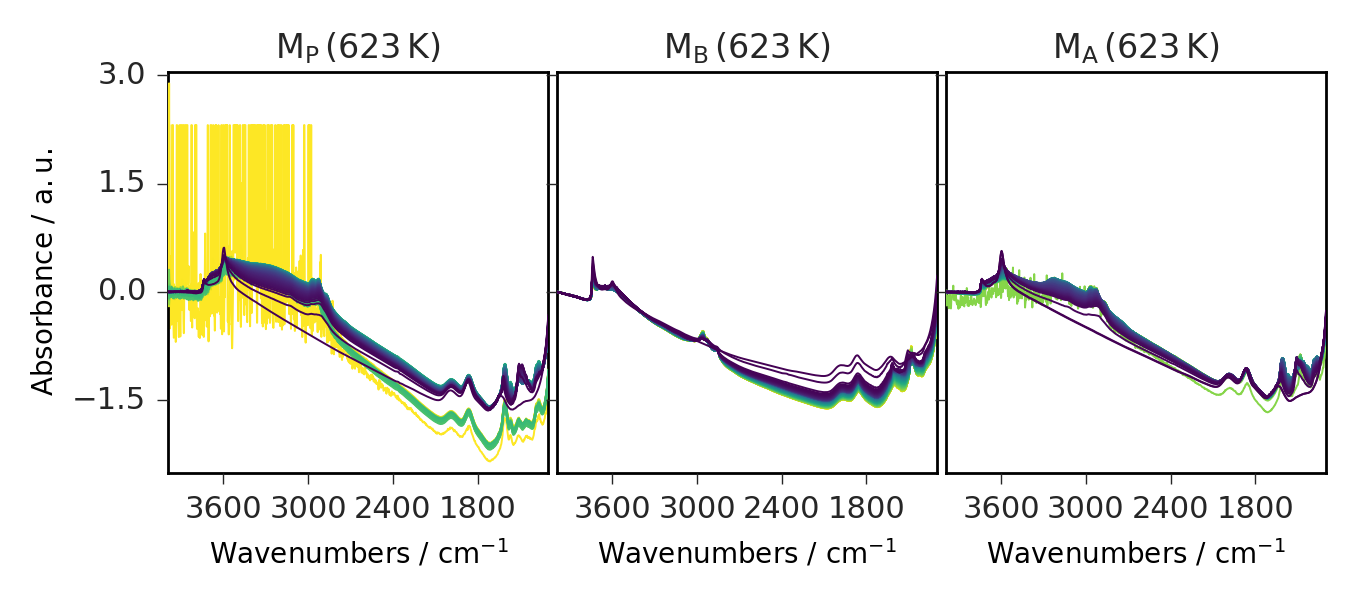

In [14]:
for p in proj.projects:   
    p.IR.remove_masks()

proj.plotIR()

### Masking bad data for rows

It appears that the data to remove correspond to some row but it is difficult to find which one in the plot above. So it may be interesting to work on transposed data (we use the operator `.T`).

First, let's make a script for plotting the transposed data

In [15]:
%%addscript -p proj -o plotIR_T

datasets_T =[]
labels = []

for p in reversed(proj.projects):   # we put the parent first this way
    datasets_T.append(p.IR.T)
    labels.append(p.label) 
    
_ = multiplot_stack(sources=datasets_T, labels=labels, 
                nrow=1, ncol=3, sharex=False, sharez=True, 
                figsize=(6.8,3), dpi=100, style='sans')

'Script plotIR_T created.'

<IPython.core.display.Javascript object>


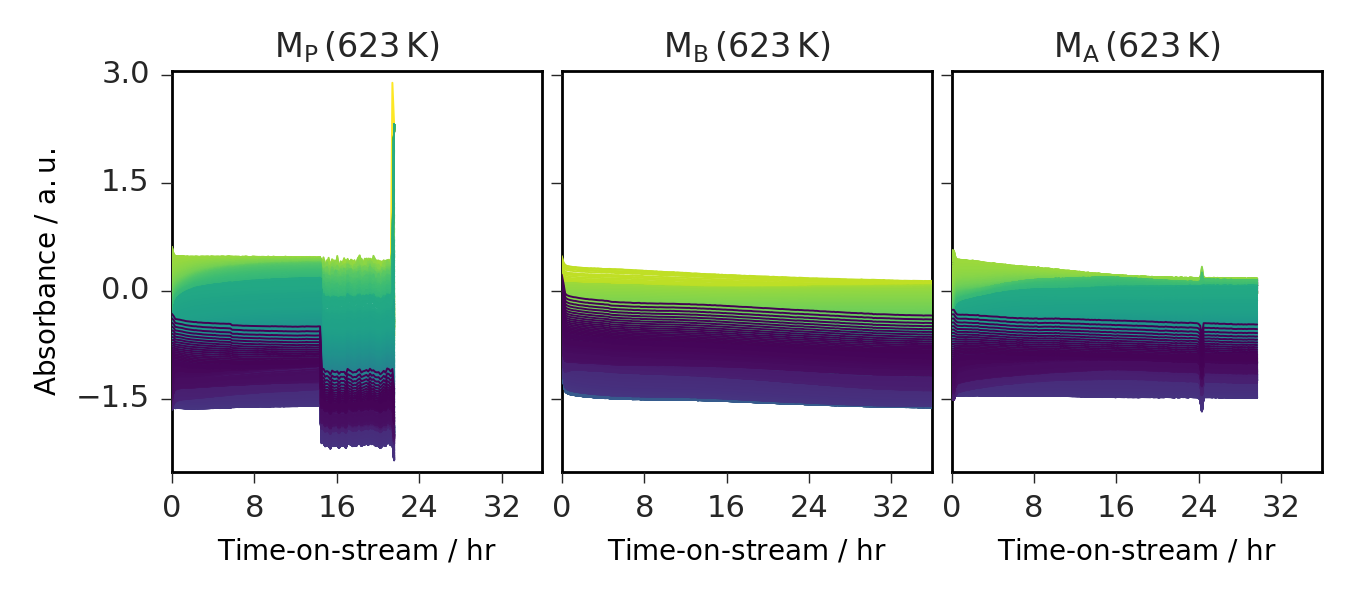

In [16]:
proj.plotIR_T()

Now mask some of the rows, that are clearly not correct

<IPython.core.display.Javascript object>


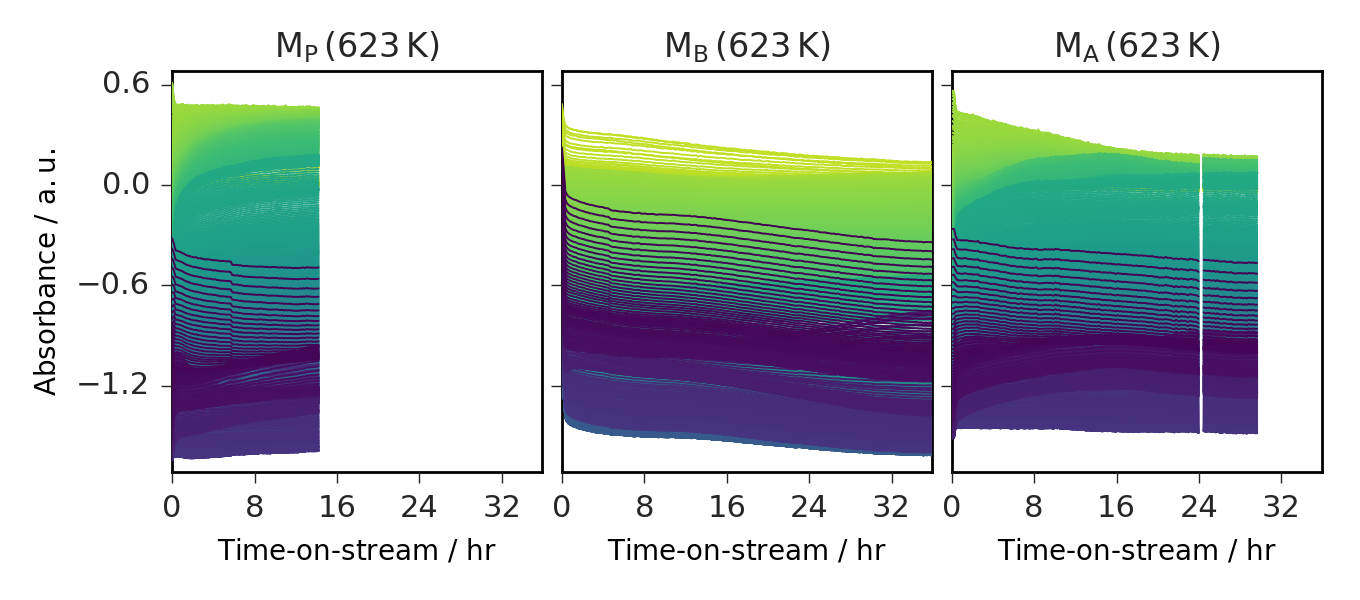

<IPython.core.display.Javascript object>


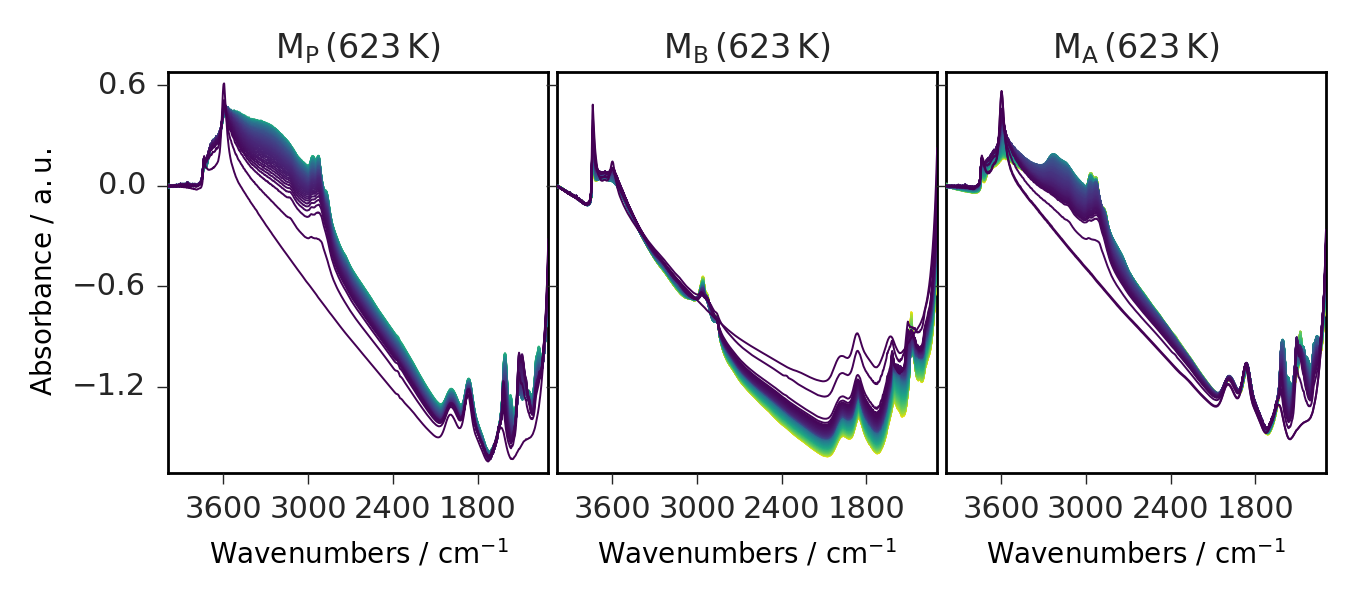

In [17]:
proj.P350.IR[14.4:24.]=masked
proj.A350.IR[24.17:24.36]=masked

proj.plotIR_T()
proj.plotIR()

## Make our final preprocessing script

OK, the data are now clean. Let's update our `preprocess` script with a summary of all actions, so that we can apply this next time.

In [18]:
%%addscript -p proj -o preprocess

# slicing
for p in proj.projects:
    p.IR[:, 3990.:1300., INPLACE]   # we slice the data inplace 
    p.IR = p.IR - p.IR[:,3990.]     # we remove the offset 

# mask some rows
proj.P350.IR[14.4:24.]=masked        
proj.A350.IR[24.17:24.36]=masked
 

'Script preprocess created.'

Save these scripts

In [19]:
proj.save(overwrite_data=False)